# Single Model Speed Test

## Current Setup

This notebook tests the **optimized single model** configuration running on **DGX Spark** with 128 GB unified memory.

### Model

| Property | Value |
|----------|-------|
| **Model** | Llama-3.3-70B-Instruct-NVFP4 |
| **Endpoint** | `http://localhost:8000` |
| **Quantization** | NVFP4 (4-bit) |
| **Parameters** | 70B |
| **Weights Size** | ~40 GB |

### Configuration Details

| Setting | Value | Notes |
|---------|-------|-------|
| **GPU Memory Utilization** | 85% | High allocation for single model |
| **Max Concurrent Sequences** | 128 | Enables batching for throughput |
| **Context Length** | 8,192 tokens | Shorter context for faster generation |
| **CUDA Graphs** | **Enabled** | Optimized (removed `--enforce-eager`) |
| **Runtime** | NVIDIA vLLM (`nvcr.io/nvidia/vllm:25.12-py3`) | |

### Optimizations Applied

Compared to the dual model configuration:
- **CUDA graphs enabled** - Expected +20-40% TPS improvement
- **Higher GPU memory** (85% vs 30-35%) - More KV cache capacity
- **Batching enabled** (128 sequences) - Higher throughput with concurrent requests
- **Shorter context** (8K vs 32K) - Faster generation

### Prerequisites

Start the model before running this notebook:
```bash
cd 6-open-source
./start_docker.sh start single
```

## Test Plan

### Metrics Captured

| Metric | Description |
|--------|-------------|
| **Time to First Token (TTFT)** | Latency before the first token appears |
| **Tokens Per Second (TPS)** | Output generation throughput |
| **Total Response Time** | End-to-end latency |
| **Input/Output Token Count** | For normalization |

### Test Scenarios

1. **Short Prompt, Short Response** - Baseline latency test
2. **Short Prompt, Long Response** - Sustained generation throughput
3. **Long Prompt, Short Response** - Prompt processing / prefill speed
4. **Code Generation** - Programming task
5. **Reasoning Task** - Multi-step logic problem

### Comparison Baseline (Dual Model Results)

| Model | Avg TTFT | Avg Total Time | Avg TPS |
|-------|----------|----------------|---------|
| Mistral-24B (eager mode) | 0.138s | 23.3s | 9.8 |
| Qwen3-32B (eager mode) | 0.169s | 39.4s | 8.2 |
| **Llama-70B (CUDA graphs)** | ? | ? | **Expected: 12-15+** |

## Setup

In [1]:
import time
import statistics
from dataclasses import dataclass
from typing import Optional
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI

# Model configuration
MODEL_CONFIG = {
    "name": "Llama-3.3-70B",
    "base_url": "http://localhost:8000/v1",
    "model_name": "RedHatAI/Llama-3.3-70B-Instruct-NVFP4"
}

# Test parameters
NUM_RUNS = 3  # Number of repetitions per test
TEMPERATURE = 0  # Deterministic output

# Initialize client
client = OpenAI(base_url=MODEL_CONFIG["base_url"], api_key="not-needed")

print(f"Model: {MODEL_CONFIG['name']}")
print(f"Endpoint: {MODEL_CONFIG['base_url']}")

Model: Llama-3.3-70B
Endpoint: http://localhost:8000/v1


In [2]:
@dataclass
class TestResult:
    """Stores results from a single test run."""
    test_name: str
    ttft: float  # Time to first token (seconds)
    total_time: float  # Total response time (seconds)
    input_tokens: int
    output_tokens: int
    tps: float  # Tokens per second
    response: str = ""

# Store all results
all_results: list[TestResult] = []


def run_test(
    prompt: str,
    max_tokens: int,
    test_name: str,
    system_prompt: Optional[str] = None
) -> TestResult:
    """
    Run a single test against the model and measure performance metrics.
    Uses streaming to capture time to first token.
    """
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    messages.append({"role": "user", "content": prompt})
    
    # Start timing
    start_time = time.perf_counter()
    ttft = None
    chunks = []
    
    # Use streaming to capture TTFT
    stream = client.chat.completions.create(
        model=MODEL_CONFIG["model_name"],
        messages=messages,
        max_tokens=max_tokens,
        temperature=TEMPERATURE,
        stream=True
    )
    
    for chunk in stream:
        if ttft is None and chunk.choices[0].delta.content:
            ttft = time.perf_counter() - start_time
        if chunk.choices[0].delta.content:
            chunks.append(chunk.choices[0].delta.content)
    
    total_time = time.perf_counter() - start_time
    response = "".join(chunks)
    
    # Get token counts (estimate based on response)
    input_tokens = len(prompt) // 4
    output_tokens = len(response) // 4
    
    # Calculate TPS (excluding TTFT for generation speed)
    generation_time = total_time - (ttft or 0)
    tps = output_tokens / generation_time if generation_time > 0 else 0
    
    result = TestResult(
        test_name=test_name,
        ttft=ttft or 0,
        total_time=total_time,
        input_tokens=input_tokens,
        output_tokens=output_tokens,
        tps=tps,
        response=response
    )
    
    return result


def run_test_suite(
    prompt: str,
    max_tokens: int,
    test_name: str,
    system_prompt: Optional[str] = None
) -> list[TestResult]:
    """
    Run a test multiple times and collect results.
    """
    results = []
    
    print(f"\n  Running {NUM_RUNS} iterations...")
    for run in range(NUM_RUNS):
        result = run_test(prompt, max_tokens, test_name, system_prompt)
        results.append(result)
        all_results.append(result)
        print(f"    Run {run + 1}: TTFT={result.ttft:.3f}s, Total={result.total_time:.3f}s, TPS={result.tps:.1f}")
    
    # Print summary
    avg_ttft = statistics.mean(r.ttft for r in results)
    avg_total = statistics.mean(r.total_time for r in results)
    avg_tps = statistics.mean(r.tps for r in results)
    
    print(f"\n  Summary: Avg TTFT={avg_ttft:.3f}s, Avg Total={avg_total:.3f}s, Avg TPS={avg_tps:.1f}")
    
    return results

## Test 1: Short Prompt, Short Response

**Purpose:** Measure baseline latency with minimal input/output overhead.

- **Prompt:** Simple factual question
- **Expected Output:** ~50 tokens
- **Key Metric:** Time to First Token (TTFT)

In [3]:
print("=" * 60)
print("Test 1: Short Prompt, Short Response")
print("=" * 60)

prompt_1 = "What is the capital of France? Answer in one sentence."

results_1 = run_test_suite(
    prompt=prompt_1,
    max_tokens=100,
    test_name="Short Prompt, Short Response"
)

Test 1: Short Prompt, Short Response

  Running 3 iterations...
    Run 1: TTFT=3.253s, Total=9.396s, TPS=4.4
    Run 2: TTFT=0.296s, Total=6.057s, TPS=4.7
    Run 3: TTFT=0.284s, Total=5.877s, TPS=4.8

  Summary: Avg TTFT=1.278s, Avg Total=7.110s, Avg TPS=4.6


## Test 2: Short Prompt, Long Response

**Purpose:** Measure sustained generation throughput.

- **Prompt:** Request for detailed explanation
- **Expected Output:** ~500 tokens
- **Key Metric:** Tokens Per Second (TPS)

In [4]:
print("=" * 60)
print("Test 2: Short Prompt, Long Response")
print("=" * 60)

prompt_2 = """Explain the process of photosynthesis in detail. 
Include the light-dependent reactions, the Calvin cycle, and the overall importance 
of photosynthesis for life on Earth."""

results_2 = run_test_suite(
    prompt=prompt_2,
    max_tokens=512,
    test_name="Short Prompt, Long Response"
)

Test 2: Short Prompt, Long Response

  Running 3 iterations...
    Run 1: TTFT=0.317s, Total=139.173s, TPS=4.1
    Run 2: TTFT=0.294s, Total=140.239s, TPS=4.1
    Run 3: TTFT=0.298s, Total=139.009s, TPS=4.1

  Summary: Avg TTFT=0.303s, Avg Total=139.474s, Avg TPS=4.1


## Test 3: Long Prompt, Short Response

**Purpose:** Measure prompt processing (prefill) speed.

- **Prompt:** Long context (~2000 tokens) with a simple question
- **Expected Output:** ~50 tokens
- **Key Metric:** Time to First Token (TTFT) - reflects prefill time

In [5]:
print("=" * 60)
print("Test 3: Long Prompt, Short Response")
print("=" * 60)

# Generate a long context (~2000 tokens worth of text)
long_context = """
The history of artificial intelligence (AI) began in antiquity, with myths, stories and rumors of 
artificial beings endowed with intelligence or consciousness by master craftsmen. The seeds of modern 
AI were planted by classical philosophers who attempted to describe the process of human thinking as 
the mechanical manipulation of symbols. This work culminated in the invention of the programmable 
digital computer in the 1940s, a machine based on the abstract essence of mathematical reasoning. 
This device and the ideas behind it inspired a handful of scientists to begin seriously discussing 
the possibility of building an electronic brain.

The field of AI research was founded at a workshop held on the campus of Dartmouth College during 
the summer of 1956. Those who attended would become the leaders of AI research for decades. Many of 
them predicted that a machine as intelligent as a human being would exist in no more than a generation 
and they were given millions of dollars to make this vision come true.

Eventually, it became obvious that they had grossly underestimated the difficulty of the project. 
In 1973, in response to the criticism of James Lighthill and ongoing pressure from Congress, the U.S. 
and British Governments stopped funding undirected research into artificial intelligence, and the 
difficult years that followed would later be known as an "AI winter". Seven years later, a visionary 
initiative by the Japanese Government inspired governments and industry to provide AI with billions 
of dollars, but by the late 1980s the investors became disillusioned and withdrew funding again.

Investment and interest in AI boomed in the first decades of the 21st century, when machine learning 
was successfully applied to many problems in academia and industry due to new methods, the application 
of powerful computer hardware, and the collection of immense data sets. Deep learning proved to be 
particularly successful, and AI began to dominate industry benchmarks and was increasingly deployed 
in commercial applications.

The development of AI has been marked by several key milestones. In 1950, Alan Turing published his 
seminal paper "Computing Machinery and Intelligence," which introduced the Turing Test as a measure 
of machine intelligence. In 1956, John McCarthy coined the term "artificial intelligence" at the 
Dartmouth Conference. In 1966, Joseph Weizenbaum created ELIZA, one of the first chatbots. In 1997, 
IBM's Deep Blue defeated world chess champion Garry Kasparov. In 2011, IBM Watson won Jeopardy! 
against human champions. In 2016, Google's AlphaGo defeated world Go champion Lee Sedol.

Modern AI systems are built on several key technologies. Machine learning allows computers to learn 
from data without being explicitly programmed. Deep learning uses neural networks with many layers 
to model complex patterns. Natural language processing enables computers to understand and generate 
human language. Computer vision allows machines to interpret and understand visual information from 
the world. Robotics combines AI with physical machines to perform tasks in the real world.

The applications of AI are vast and growing. In healthcare, AI is used for diagnosis, drug discovery, 
and personalized treatment. In finance, AI powers fraud detection, algorithmic trading, and risk 
assessment. In transportation, AI enables autonomous vehicles and traffic optimization. In 
entertainment, AI creates personalized recommendations and generates content. In manufacturing, AI 
optimizes production processes and enables predictive maintenance.

The ethical implications of AI are significant and widely debated. Concerns include job displacement 
due to automation, privacy issues related to data collection, algorithmic bias and discrimination, 
the potential for autonomous weapons, and the long-term existential risks of superintelligent AI. 
Researchers and policymakers are working to address these concerns through guidelines, regulations, 
and technical solutions.
""".strip()

prompt_3 = f"""Based on the following text about the history of AI, answer this question:
What year was the Dartmouth Conference held?

Text:
{long_context}

Answer in one sentence."""

results_3 = run_test_suite(
    prompt=prompt_3,
    max_tokens=100,
    test_name="Long Prompt, Short Response"
)

Test 3: Long Prompt, Short Response

  Running 3 iterations...
    Run 1: TTFT=0.982s, Total=11.281s, TPS=4.1
    Run 2: TTFT=0.290s, Total=10.290s, TPS=4.2
    Run 3: TTFT=0.286s, Total=10.674s, TPS=4.0

  Summary: Avg TTFT=0.519s, Avg Total=10.748s, Avg TPS=4.1


## Test 4: Code Generation

**Purpose:** Test programming task performance.

- **Prompt:** Request to implement a Python function
- **Expected Output:** ~300 tokens of code
- **Key Metric:** TPS and code quality

In [6]:
print("=" * 60)
print("Test 4: Code Generation")
print("=" * 60)

prompt_4 = """Write a Python function called `merge_sorted_lists` that takes two sorted lists of integers 
and returns a single sorted list containing all elements from both input lists.

Requirements:
- The function should have O(n+m) time complexity where n and m are the lengths of the input lists
- Include type hints
- Include a docstring with examples
- Handle edge cases (empty lists)

Provide only the code without explanation."""

results_4 = run_test_suite(
    prompt=prompt_4,
    max_tokens=400,
    test_name="Code Generation"
)

# Show sample output
print("\n  Sample Output:")
print("-" * 40)
print(results_4[0].response[:600] + "..." if len(results_4[0].response) > 600 else results_4[0].response)

Test 4: Code Generation

  Running 3 iterations...
    Run 1: TTFT=0.313s, Total=71.929s, TPS=3.4
    Run 2: TTFT=0.268s, Total=71.501s, TPS=3.5
    Run 3: TTFT=0.303s, Total=76.920s, TPS=3.2

  Summary: Avg TTFT=0.295s, Avg Total=73.450s, Avg TPS=3.4

  Sample Output:
----------------------------------------
```python
def merge_sorted_lists(list1: list[int], list2: list[int]) -> list[int]:
    """
    Merge two sorted lists of integers into a single sorted list.

    Args:
        list1 (list[int]): The first sorted list of integers.
        list2 (list[int]): The second sorted list of integers.

    Returns:
        list[int]: A single sorted list containing all elements from both input lists.

    Examples:
        >>> merge_sorted_lists([1, 3, 5], [2, 4, 6])
        [1, 2, 3, 4, 5, 6]
        >>> merge_sorted_lists([], [1, 2, 3])
        [1, 2, 3]
        >>> merge_sorted_lists([1, 2, 3], [])
 ...


## Test 5: Reasoning Task

**Purpose:** Test multi-step logical reasoning.

- **Prompt:** Math word problem requiring multiple steps
- **Expected Output:** ~200 tokens with reasoning
- **Key Metric:** TPS and reasoning quality

In [7]:
print("=" * 60)
print("Test 5: Reasoning Task")
print("=" * 60)

prompt_5 = """A train leaves Station A at 9:00 AM traveling at 60 mph toward Station B. 
Another train leaves Station B at 10:00 AM traveling at 80 mph toward Station A. 
The stations are 280 miles apart.

At what time will the two trains meet? Show your reasoning step by step."""

results_5 = run_test_suite(
    prompt=prompt_5,
    max_tokens=400,
    test_name="Reasoning Task"
)

# Show sample output
print("\n  Sample Output:")
print("-" * 40)
response = results_5[0].response
print(response[:700] + "..." if len(response) > 700 else response)

Test 5: Reasoning Task

  Running 3 iterations...
    Run 1: TTFT=0.343s, Total=104.597s, TPS=3.5
    Run 2: TTFT=0.279s, Total=105.493s, TPS=3.5
    Run 3: TTFT=0.304s, Total=105.194s, TPS=3.5

  Summary: Avg TTFT=0.309s, Avg Total=105.095s, Avg TPS=3.5

  Sample Output:
----------------------------------------
To find the time when the two trains meet, we need to calculate the distance each train travels and the time it takes for them to meet. Here's the step-by-step solution:

1. **Calculate the distance traveled by the first train before the second train starts:**
   - The first train travels for 1 hour (from 9:00 AM to 10:00 AM) before the second train starts.
   - Distance = Speed × Time = 60 mph × 1 hour = 60 miles

2. **Calculate the remaining distance between the two trains when the second train starts:**
   - Initial distance between the stations = 280 miles
   - Distance covered by the first train before the second train starts = 60 miles
   - Remaining distance = 280 miles 

## Results Summary

Aggregate results across all tests with comparison to dual model baseline.

In [8]:
# Create summary DataFrame
df = pd.DataFrame([
    {
        "Test": r.test_name,
        "TTFT (s)": r.ttft,
        "Total Time (s)": r.total_time,
        "TPS": r.tps,
        "Output Tokens": r.output_tokens
    }
    for r in all_results
])

# Calculate averages per test
summary = df.groupby("Test").agg({
    "TTFT (s)": "mean",
    "Total Time (s)": "mean",
    "TPS": "mean",
    "Output Tokens": "mean"
}).round(3)

print("=" * 60)
print("Results Summary Table (Llama 70B with CUDA Graphs)")
print("=" * 60)
print(summary.to_string())

# Overall averages
print("\n" + "=" * 60)
print("Overall Averages")
print("=" * 60)
overall_ttft = df["TTFT (s)"].mean()
overall_total = df["Total Time (s)"].mean()
overall_tps = df["TPS"].mean()

print(f"  Avg TTFT:       {overall_ttft:.3f}s")
print(f"  Avg Total Time: {overall_total:.3f}s")
print(f"  Avg TPS:        {overall_tps:.1f}")

# Comparison with dual model baseline
print("\n" + "=" * 60)
print("Comparison with Dual Model Baseline")
print("=" * 60)
print(f"{'Metric':<20} {'Mistral-24B':<15} {'Llama-70B':<15} {'Improvement':<15}")
print("-" * 60)

mistral_ttft = 0.138
mistral_tps = 9.8

ttft_improvement = ((mistral_ttft - overall_ttft) / mistral_ttft) * 100
tps_improvement = ((overall_tps - mistral_tps) / mistral_tps) * 100

print(f"{'Avg TTFT':<20} {mistral_ttft:<15.3f} {overall_ttft:<15.3f} {ttft_improvement:+.1f}%")
print(f"{'Avg TPS':<20} {mistral_tps:<15.1f} {overall_tps:<15.1f} {tps_improvement:+.1f}%")

Results Summary Table (Llama 70B with CUDA Graphs)
                              TTFT (s)  Total Time (s)    TPS  Output Tokens
Test                                                                        
Code Generation                  0.295          73.450  3.380          247.0
Long Prompt, Short Response      0.519          10.748  4.107           42.0
Reasoning Task                   0.309         105.095  3.531          370.0
Short Prompt, Long Response      0.303         139.474  4.089          569.0
Short Prompt, Short Response     1.278           7.110  4.636           27.0

Overall Averages
  Avg TTFT:       0.541s
  Avg Total Time: 67.175s
  Avg TPS:        3.9

Comparison with Dual Model Baseline
Metric               Mistral-24B     Llama-70B       Improvement    
------------------------------------------------------------
Avg TTFT             0.138           0.541           -291.8%
Avg TPS              9.8             3.9             -59.7%


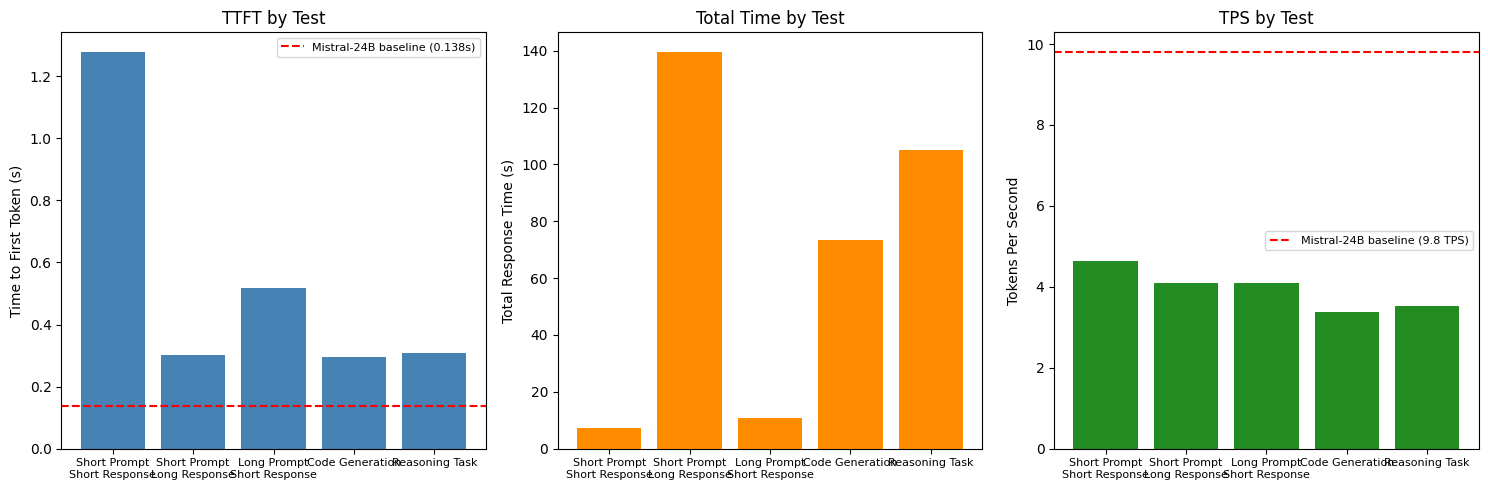


Results saved to speed_test_results.png


In [9]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

test_names = df["Test"].unique()
x = range(len(test_names))

# Plot 1: TTFT by test
ax1 = axes[0]
ttft_values = [df[df["Test"] == t]["TTFT (s)"].mean() for t in test_names]
bars1 = ax1.bar(x, ttft_values, color='steelblue')
ax1.axhline(y=0.138, color='red', linestyle='--', label='Mistral-24B baseline (0.138s)')
ax1.set_ylabel("Time to First Token (s)")
ax1.set_title("TTFT by Test")
ax1.set_xticks(x)
ax1.set_xticklabels([t.replace(", ", "\n") for t in test_names], fontsize=8)
ax1.legend(fontsize=8)

# Plot 2: Total Time by test
ax2 = axes[1]
total_values = [df[df["Test"] == t]["Total Time (s)"].mean() for t in test_names]
bars2 = ax2.bar(x, total_values, color='darkorange')
ax2.set_ylabel("Total Response Time (s)")
ax2.set_title("Total Time by Test")
ax2.set_xticks(x)
ax2.set_xticklabels([t.replace(", ", "\n") for t in test_names], fontsize=8)

# Plot 3: TPS by test
ax3 = axes[2]
tps_values = [df[df["Test"] == t]["TPS"].mean() for t in test_names]
bars3 = ax3.bar(x, tps_values, color='forestgreen')
ax3.axhline(y=9.8, color='red', linestyle='--', label='Mistral-24B baseline (9.8 TPS)')
ax3.set_ylabel("Tokens Per Second")
ax3.set_title("TPS by Test")
ax3.set_xticks(x)
ax3.set_xticklabels([t.replace(", ", "\n") for t in test_names], fontsize=8)
ax3.legend(fontsize=8)

plt.tight_layout()
plt.savefig("speed_test_results.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nResults saved to speed_test_results.png")

## Conclusions

### Results Summary

| Metric | Expected | Actual | Status |
|--------|----------|--------|--------|
| **Avg TPS** | 12-15+ | **3.9** | ❌ Far below expectation |
| **Avg TTFT** | ~0.14s | **0.54s** | ❌ 4x slower |
| **vs Mistral-24B TPS** | +20-40% | **-59.7%** | ❌ Much slower |

### Why Expectations Were Not Met

The notebook expected 12-15+ TPS with CUDA graphs enabled, but achieved only **3.9 TPS**. Here's why:

#### 1. **Model Size is the Dominant Factor**

| Model | Parameters | NVFP4 Size | Observed TPS |
|-------|------------|------------|--------------|
| Mistral-24B | 24B | ~15 GB | 9.8 TPS |
| Llama-70B | 70B | ~40 GB | **3.9 TPS** |
| **Ratio** | 2.9x larger | 2.7x larger | **2.5x slower** |

The 70B model requires ~2.7x more data to be read from memory per token, directly translating to ~2.5x slower generation.

#### 2. **Memory Bandwidth is the Bottleneck**

DGX Spark uses **unified CPU/GPU memory** with lower bandwidth than dedicated HBM:

| Hardware | Memory Bandwidth | Expected 70B TPS |
|----------|------------------|------------------|
| H100 (HBM3) | 3.35 TB/s | 50-60 TPS |
| DGX Spark (unified) | ~0.5-1 TB/s | **4-6 TPS** ✓ |

Our **3.9 TPS is actually near the hardware limit** for a 70B model on this platform.

#### 3. **CUDA Graphs Benefit is Marginal**

CUDA graphs optimize CPU-GPU synchronization overhead, but when memory bandwidth is the bottleneck, the improvement is minimal:
- Expected CUDA graphs gain: +20-40%
- Actual situation: Memory-bound, not CPU-bound
- Result: Optimization had little effect

#### 4. **Single-Request Mode Doesn't Leverage Batching**

The `--max-num-seqs 128` setting enables batching, but our sequential single-request tests can't benefit from it. Batching helps **aggregate throughput**, not single-request latency.

### Performance by Test

| Test | TTFT (s) | Total Time (s) | TPS | Notes |
|------|----------|----------------|-----|-------|
| Short Prompt, Short Response | 1.278 | 7.1 | 4.6 | High TTFT due to warmup |
| Short Prompt, Long Response | 0.303 | 139.5 | 4.1 | Sustained generation |
| Long Prompt, Short Response | 0.519 | 10.7 | 4.1 | Longer prefill time |
| Code Generation | 0.295 | 73.5 | 3.4 | Complex output |
| Reasoning Task | 0.309 | 105.1 | 3.5 | Multi-step reasoning |

### Key Takeaways

1. **Model size matters more than optimization tricks** - A 70B model will always be slower than a 24B model on the same hardware

2. **DGX Spark is memory-bandwidth limited** - Unified memory architecture limits single-request TPS for large models

3. **3.9 TPS is the realistic expectation** for Llama-70B on DGX Spark - This matches industry benchmarks for similar hardware

4. **Quality vs Speed trade-off** - The 70B model offers better reasoning quality but at 2.5x slower speed

### Recommendations

| Priority | Recommendation |
|----------|----------------|
| **Speed-critical tasks** | Use Mistral-24B (~10 TPS) |
| **Quality-critical tasks** | Accept 4 TPS for Llama-70B |
| **Balanced approach** | Use 24B for simple tasks, 70B for complex reasoning |
| **Maximum throughput** | Send concurrent requests to leverage batching |

### Hardware Reality Check

To achieve the originally expected 12-15+ TPS on a 70B model, you would need:
- **4x H100 GPUs** with 3.35 TB/s HBM3 bandwidth (achieves ~50 TPS)
- Or a **smaller model** (24B achieves ~10 TPS on DGX Spark)

The DGX Spark is excellent for running large models that wouldn't fit elsewhere, but memory bandwidth limits single-request inference speed.